# TEST FACE RECOGNITION

In [1]:
import os
import re
import cv2
import time
import pickle
import numpy as np
from sklearn import neighbors

## PARAS

In [2]:
LWF_FOLDER_FACE = '/Users/khoa1799/GitHub/DATA/LWF/data'
LWF_CUT_FOLDER_FACE = '/Users/khoa1799/GitHub/DATA/LWF/cut_data'

LWF_PATH_USER_ID = '/Users/khoa1799/GitHub/E-Healthcare-System/jupyter/model/LWF_ID_Face'
LWF_PATH_USER_IMG_ENCODED = '/Users/khoa1799/GitHub/E-Healthcare-System/jupyter/model/LWF_Encoded_Face'
LWF_KNN_MODEL_PATH = "/Users/khoa1799/GitHub/E-Healthcare-System/jupyter/model/LWF_knn_clf_model.clf"
LWF_SVM_MODEL_PATH = "/Users/khoa1799/GitHub/E-Healthcare-System/jupyter/model/LWF_svm_clf_model.clf"

PREDICTOR_5_POINT_MODEL = '/Users/khoa1799/GitHub/E-Healthcare-System/jupyter/model/shape_predictor_5_face_landmarks.dat'
RESNET_MODEL = '/Users/khoa1799/GitHub/E-Healthcare-System/jupyter/model/dlib_face_recognition_resnet_model_v1.dat'

IMAGE_SIZE = 150

## FACE ENCODING

In [3]:
import dlib
pose_predictor_5_point = dlib.shape_predictor(PREDICTOR_5_POINT_MODEL)
face_encoder = dlib.face_recognition_model_v1(RESNET_MODEL)

In [4]:
def face_encodings(face_image, known_face_locations):
    raw_landmarks = _raw_face_landmarks(face_image, known_face_locations)
    return [np.array(face_encoder.compute_face_descriptor(face_image, raw_landmark_set, 1)) for raw_landmark_set in raw_landmarks]

def _css_to_rect(css):
    return dlib.rectangle(css[3], css[0], css[1], css[2])

def _raw_face_landmarks(face_image, face_locations):
    if face_locations is None:
        face_locations = _raw_face_locations(face_image)
    else:
        face_locations = [_css_to_rect(face_location) for face_location in face_locations]

    pose_predictor = pose_predictor_5_point

    return [pose_predictor(face_image, face_location) for face_location in face_locations]

## GET THE BOUNDING BOX CONTAINNING FACE IN IMAGE BUT NOT ALIGNED

In [5]:
def Cut_Img(loaded_img):
    ret_img = loaded_img.copy()
    
    max_fra = max( loaded_img.shape[0], loaded_img.shape[1] ) / 320
    new_height = int( loaded_img.shape[0] / max_fra )
    new_width = int( loaded_img.shape[1] / max_fra )

    resized_img = cv2.resize(loaded_img, ( new_width, new_height ))
    RGB_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(RGB_resized_img)
    for (top, right, bottom, left) in face_locations:
        top *= max_fra
        bottom *= max_fra
        left *= max_fra
        right *= max_fra

        return len(face_locations), ret_img[int(top):int(bottom),int(left):int(right)]
    return 0, 0

## LOAD AND SAVE MODEL

In [6]:
def SaveData(known_face_IDs, known_face_encodings, path_user_id, path_user_img_encoded):
    with open(path_user_id, mode='wb') as fp_1:
        pickle.dump(known_face_IDs, fp_1)

    with open(path_user_img_encoded, 'wb') as fp_2:
        pickle.dump(known_face_encodings, fp_2)

def SaveKNNModel(knn_clf, path_model):
    if path_model is not None:
        with open(path_model, 'wb') as f:
            pickle.dump(knn_clf, f)

def SaveSVMModel(svm_clf, path_model):
    if path_model is not None:
        with open(path_model, 'wb') as f:
            pickle.dump(svm_clf, f)

def LoadData(path_user_id, path_user_img_encoded):
    known_face_IDs = None
    known_face_encodings = None
    if not os.path.exists(path_user_id):
        print("There is no user id face to load")
        exit(-1)

    with open (path_user_id, 'rb') as fp_1:
        known_face_IDs = pickle.load(fp_1)

    if not os.path.exists(path_user_img_encoded):
        print("There is no user encoding face to load")
        exit(-1)

    with open (path_user_img_encoded, 'rb') as fp_2:
        known_face_encodings = pickle.load(fp_2)
    
    return known_face_IDs, known_face_encodings
        
def LoadKNNModel(path_model):
    if not os.path.exists(path_model):
        print("There is KNN model to load")
        exit(-1)

    with open(path_model, 'rb') as f:
        knn_clf = pickle.load(f)
        return knn_clf

def LoadSVMModel(path_model):
    if not os.path.exists(path_model):
        print("There is KNN model to load")
        exit(-1)

    with open(path_model, 'rb') as f:
        svm_clf = pickle.load(f)
        return svm_clf

# LWF DATASET

## Preprocessing

In [8]:
import cv2
import numpy as np
BASE_BRIGHTNESS = 180
IMAGE_SIZE = 150

def adjust_brightness(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    v = hsv_img[:, :, 2]
    mean_v = np.mean(v)
    diff = BASE_BRIGHTNESS - mean_v
                   
    if diff < 0:
        v = np.where(v < abs(diff), v, v + diff)
    else:
        v = np.where( v + diff > 255, v, v + diff)

    hsv_img[:, :, 2] = v
    ret_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    # return BRG image
    return ret_img

def preprocessing(img):
    # Resize image
    resized_img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    # Adjust bright image
    adjusted_brightness_img = adjust_brightness(resized_img)

    # Change to RGB image
    GRAY_resized_img = cv2.cvtColor(adjusted_brightness_img, cv2.COLOR_BGR2GRAY)

    # return RGB image
    return GRAY_resized_img

# TEST LWF DATASET

In [9]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [10]:
lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=1.5, color=True)

### Create test, train, and unknown dataset

In [11]:
import cv2
import matplotlib.pyplot as plt

# List BGR image
X = lfw_people.images
X = [cv2.normalize(src=x, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)for x in X]
X = [cv2.cvtColor(x, cv2.COLOR_RGB2BGR) for x in X]

Y = lfw_people.target
Y = [y for y in Y]

freq = {}
min = 10000
max = 0

for i in Y:
    if (i in freq): 
        freq[i] += 1
    else: 
        freq[i] = 1
    
    if freq[i] > max:
        max = freq[i]
    if freq[i] < min:
        min = freq[i]
        
print("Minimum images in one class: {}".format(min))
print("Maximum images in one class: {}".format(max))
print()

dict_Y_greater_5 = {}
list_Y_greater_5 = []
list_Y_unknown = []

for i in freq:
    if freq[i] <=5:
        list_Y_unknown.append(i)
    elif freq[i] > 5:
        dict_Y_greater_5[i] = 0
        list_Y_greater_5.append(i)

# Create unknown people data
X_unknown = []
Y_unknown = []
X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(len(Y)):
    if Y[i] in list_Y_unknown:
        X_unknown.append(X[i])
        Y_unknown.append(Y[i])
    else:
        dict_Y_greater_5[Y[i]] += 1
        if dict_Y_greater_5[Y[i]] <=5:
            X_train.append(X[i])
            Y_train.append(Y[i])
        else:
            X_test.append(X[i])
            Y_test.append(Y[i])

print("Total images: {}".format(len(Y)))
print("Total images for train: {}".format(len(Y_train)))
print("Total images for test: {}".format(len(Y_test)))
print("Total images unknown: {}".format(len(Y_unknown)))

Minimum images in one class: 1
Maximum images in one class: 530

Total images: 13233
Total images for train: 1555
Total images for test: 3870
Total images unknown: 7808


In [12]:
print("Shape of each images: {}".format(X[0].shape))

Shape of each images: (187, 141, 3)


### CREATE EMBEDDED CODE AND USER ID

In [13]:
known_face_IDs = []
known_face_encodings = []
IMAGE_SIZE = 150

time_start = time.time()
for i in range(len(X_train)):
    img = X_train[i]
    user_ID = Y_train[i]
    
    preprocessed_img = preprocessing(img)

    embedded_face = face_encodings(preprocessed_img, [(0,IMAGE_SIZE,IMAGE_SIZE,0)])[0]

    known_face_encodings.append(embedded_face)
    known_face_IDs.append(user_ID)

SaveData(known_face_IDs, known_face_encodings, LWF_PATH_USER_ID, LWF_PATH_USER_IMG_ENCODED)
print("Time load data {}".format(time.time() - time_start))

TypeError: compute_face_descriptor(): incompatible function arguments. The following argument types are supported:
    1. (self: _dlib_pybind11.face_recognition_model_v1, img: numpy.ndarray[(rows,cols,3),uint8], face: _dlib_pybind11.full_object_detection, num_jitters: int=0, padding: float=0.25) -> _dlib_pybind11.vector
    2. (self: _dlib_pybind11.face_recognition_model_v1, img: numpy.ndarray[(rows,cols,3),uint8], num_jitters: int=0) -> _dlib_pybind11.vector
    3. (self: _dlib_pybind11.face_recognition_model_v1, img: numpy.ndarray[(rows,cols,3),uint8], faces: _dlib_pybind11.full_object_detections, num_jitters: int=0, padding: float=0.25) -> _dlib_pybind11.vectors
    4. (self: _dlib_pybind11.face_recognition_model_v1, batch_img: List[numpy.ndarray[(rows,cols,3),uint8]], batch_faces: List[_dlib_pybind11.full_object_detections], num_jitters: int=0, padding: float=0.25) -> _dlib_pybind11.vectorss
    5. (self: _dlib_pybind11.face_recognition_model_v1, batch_img: List[numpy.ndarray[(rows,cols,3),uint8]], num_jitters: int=0) -> _dlib_pybind11.vectors

Invoked with: <_dlib_pybind11.face_recognition_model_v1 object at 0x131f343f0>, array([[172, 176, 180, ...,  31,  30,  29],
       [173, 177, 181, ...,  29,  27,  25],
       [172, 177, 181, ...,  27,  25,  23],
       ...,
       [142, 144, 144, ..., 147, 147, 147],
       [144, 145, 145, ..., 146, 146, 144],
       [147, 147, 146, ..., 148, 147, 146]], dtype=uint8), <_dlib_pybind11.full_object_detection object at 0x132143af0>, 1

## TRAIN KNN FOR LWF

In [103]:
# KNN PARAs
NUM_NEIGHBROS = 5
KNN_ALGORITHM = 'auto'
KNN_WEIGHTS = 'uniform'

knn_clf = None
known_face_IDs = []
known_face_encodings = []

# Load data
known_face_IDs, known_face_encodings = LoadData(LWF_PATH_USER_ID, LWF_PATH_USER_IMG_ENCODED)

# Create and train the KNN classifier
time_request = time.time()
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=NUM_NEIGHBROS, algorithm=KNN_ALGORITHM, weights=KNN_WEIGHTS, metric='euclidean')

# self.__known_face_encodings is list of ndarray
# self.__known_face_IDs is list of str
knn_clf.fit(known_face_encodings, known_face_IDs)
SaveKNNModel(knn_clf, LWF_KNN_MODEL_PATH)
print("Finishing train KNN Model: {} second".format(time.time() - time_request))

Finishing train KNN Model: 0.00308990478515625 second


## Measure distance parameter

Mean correct distance: 0.3913046669594229
Max correct distance: 0.5488320656333571
Min correct distance: 0.18617529925446935
Variance correct distance: 0.002898015503305196

Mean incorrect distance: 0.5011503510295898
Max incorrect distance: 0.5560722799212208
Min incorrect distance: 0.4444566442822639
Variance incorrect distance: 0.0010349061167313678



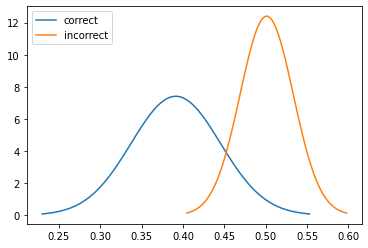

In [57]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time
import numpy as np
import os

knn_clf = None
known_face_IDs = None
known_face_encodings = None

dis_correct = []
dis_incorrect = []

total_faces = 0

# Load KNN Model
knn_clf = LoadKNNModel(LWF_KNN_MODEL_PATH)
known_face_IDs, known_face_encodings = LoadData(LWF_PATH_USER_ID, LWF_PATH_USER_IMG_ENCODED)

# print(len(known_face_IDs))
for i in range(len(X_test)):
    img = X_test[i]
    
    # Pre-processing
    preprocessed_img = preprocessing(img)
    
    # Convert to embedded code
    embedded_face = face_encodings(preprocessed_img, [(0,IMAGE_SIZE,IMAGE_SIZE,0)])[0]
    embedded_face = embedded_face.reshape(1,-1)
    
    has_face = False
    total_faces += 1
    start_time = time.time()
    
    # Classifying
    closet_distances = knn_clf.kneighbors(embedded_face, n_neighbors = 3)
    face_id = knn_clf.predict(embedded_face)
    
    for j in range(len(closet_distances)):
        if known_face_IDs[closet_distances[1][0][j]] == face_id[-1]:
            if face_id[-1] == Y_test[i]:
                dis_correct.append(closet_distances[0][0][j])
            else:
                dis_incorrect.append(closet_distances[0][0][j])
    
#     if total_faces > 3870:
    if total_faces > 1000:
        break


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

print("Mean correct distance: {}".format(np.mean(dis_correct)))
print("Max correct distance: {}".format(np.max(dis_correct)))
print("Min correct distance: {}".format(np.min(dis_correct)))
print("Variance correct distance: {}".format(np.var(dis_correct)))
print()

print("Mean incorrect distance: {}".format(np.mean(dis_incorrect)))
print("Max incorrect distance: {}".format(np.max(dis_incorrect)))
print("Min incorrect distance: {}".format(np.min(dis_incorrect)))
print("Variance incorrect distance: {}".format(np.var(dis_incorrect)))
print()

mu_correct = np.mean(dis_correct)
variance_correct = np.var(dis_correct)
sigma_correct = math.sqrt(variance_correct)
x_correct = np.linspace(mu_correct - 3*sigma_correct, mu_correct + 3*sigma_correct, 100)
y_correct = norm.pdf(x_correct, mu_correct, sigma_correct)

mu_incorrect = np.mean(dis_incorrect)
variance_incorrect = np.var(dis_incorrect)
sigma_incorrect = math.sqrt(variance_incorrect)
x_incorrect = np.linspace(mu_incorrect - 3*sigma_incorrect, mu_incorrect + 3*sigma_incorrect, 100)
y_incorrect = norm.pdf(x_incorrect, mu_incorrect, sigma_incorrect)

plt.plot(x_correct, y_correct, label='correct')
plt.plot(x_incorrect, y_incorrect, label='incorrect')
plt.legend();


## TEST FACE RECOGNITION FOR LWF DATASET

In [159]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import time
import numpy as np
import os

THRESHOLD_FACE_REC = 0.5
knn_clf = None
known_face_IDs = None
known_face_encodings = None

# known faces
predict_known_face = []
list_time_known_faces = []
total_knonw_faces = 0

# unknown faces
predict_unknown_face = []
list_time_unknown_faces = []
total_unknown_faces = 0

# Load KNN Model
knn_clf = LoadKNNModel(LWF_KNN_MODEL_PATH)
known_face_IDs, known_face_encodings = LoadData(LWF_PATH_USER_ID, LWF_PATH_USER_IMG_ENCODED)

# KNOWN FACES
for i in range(len(X_test)):
    img = X_test[i]
    
    # Pre-processing
    preprocessed_img = preprocessing(img)
    
    # Convert to embedded code
    embedded_face = face_encodings(preprocessed_img, [(0,IMAGE_SIZE,IMAGE_SIZE,0)])[0]
    embedded_face = embedded_face.reshape(1,-1)
    
    has_face = False
    total_knonw_faces += 1
    start_time = time.time()
    
    # Classifying
    closet_distances = knn_clf.kneighbors(embedded_face, n_neighbors = 5)
    face_id = knn_clf.predict(embedded_face)
    meet_condition_threshold = [closet_distances[0][0][i] <= THRESHOLD_FACE_REC for i in range(len(closet_distances[0][0]))]
    
    for j in range(len(meet_condition_threshold)):
        if meet_condition_threshold[j] and known_face_IDs[closet_distances[1][0][j]] == face_id[-1]:
            predict_known_face.append(face_id[-1])
            has_face = True
            break
    if has_face == False:
        predict_known_face.append(-1)
        
    list_time_known_faces.append(time.time() - start_time)
    # 3870
    if total_knonw_faces > 3870:
        break
        
# print(Y_test[0:total_knonw_faces])
# print(predict_known_face)
precision_score_known_faces = precision_score(Y_test[0:total_knonw_faces], predict_known_face, average='weighted')

means = np.mean(list_time_known_faces)
std = np.std(list_time_known_faces)
total_time = np.sum(list_time_known_faces)

print("Statistic report for identifying known face:")

print("\tPrecision score: {}".format(precision_score_known_faces))
print()
print("\tTotal images: {}".format(total_knonw_faces))
print("\tTotal time: {}".format(total_time))
print("\tMaximum time processing time: {}".format(numpy.max(list_time_known_faces)))
print("\tMinimum time processing time: {}".format(numpy.min(list_time_known_faces)))
print("\tMeans time: {}".format(means))
print("\tStandard deviation time: {}".format(std))
print()

# UNKNOWN FACES
unknown_faces = [-1]*len(X_unknown)
for i in range(len(X_unknown)):
    img = X_unknown[i]
    
    # Pre-processing
    preprocessed_img = preprocessing(img)
    
    # Convert to embedded code
    embedded_face = face_encodings(preprocessed_img, [(0,IMAGE_SIZE,IMAGE_SIZE,0)])[0]
    embedded_face = embedded_face.reshape(1,-1)
    
    has_face = False
    total_unknown_faces += 1
    start_time = time.time()
    
    # Classifying
    closet_distances = knn_clf.kneighbors(embedded_face, n_neighbors = 5)
    face_id = knn_clf.predict(embedded_face)
    meet_condition_threshold = [closet_distances[0][0][i] <= THRESHOLD_FACE_REC for i in range(len(closet_distances[0][0]))]
    
    for j in range(len(meet_condition_threshold)):
        if meet_condition_threshold[j] and known_face_IDs[closet_distances[1][0][j]] == face_id[-1]:
            predict_unknown_face.append(face_id[-1])
            has_face = True
            break
    if has_face == False:
        predict_unknown_face.append(-1)
        
    list_time_unknown_faces.append(time.time() - start_time)
    
#     Total face: 7808
    if total_unknown_faces > 7808:
        break
        
# print(unknown_faces[0:total_unknown_faces])
# print(predict_unknown_face)
precision_score_unknown_faces = accuracy_score(unknown_faces[0:total_unknown_faces], predict_unknown_face)

means = np.mean(list_time_unknown_faces)
std = np.std(list_time_unknown_faces)
total_time = np.sum(list_time_unknown_faces)

print("Statistic report for identifying unknown face:")

print("\tPrecision score: {}".format(precision_score_unknown_faces))
print()
print("\tTotal images: {}".format(total_unknown_faces))
print("\tTotal time: {}".format(total_time))
print("\tMaximum time processing time: {}".format(numpy.max(list_time_unknown_faces)))
print("\tMinimum time processing time: {}".format(numpy.min(list_time_unknown_faces)))
print("\tMeans time: {}".format(means))
print("\tStandard deviation time: {}".format(std))

/Users/khoa1799/.virtualenvs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Statistic report for identifying known face:
	Precision score: 0.9834455885826838

	Total images: 3870
	Total time: 6.885436773300171
	Maximum time processing time: 0.057720184326171875
	Minimum time processing time: 0.0013167858123779297
	Means time: 0.001779182628759734
	Standard deviation time: 0.0018908394816202362

Statistic report for identifying unknown face:
	Precision score: 0.7094006147540983

	Total images: 7808
	Total time: 13.241910219192505
	Maximum time processing time: 0.02983403205871582
	Minimum time processing time: 0.0014190673828125
	Means time: 0.0016959413702859253
	Standard deviation time: 0.001152126850693415


# SVM TEST

## TRAIN SVM FOR LWF

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA

svm_clf = None
known_face_IDs = []
known_face_encodings = []

# Load data
known_face_IDs, known_face_encodings = LoadData(LWF_PATH_USER_ID, LWF_PATH_USER_IMG_ENCODED)

time_request = time.time()
# print("Fitting the classifier to the training set")
# param_grid = {
#          'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#           'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#           }
# svm_clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
# print("Best estimator found by grid search:")
# print(svm_clf.best_estimator_)

# Found the best for C=5000.0 and gamma=0.0005:
svm_clf = SVC(kernel='rbf', class_weight='balanced', C=5000.0, gamma=0.0005)
svm_clf = svm_clf.fit(known_face_encodings, known_face_IDs)

print("Finishing train KNN Model: {} second".format(time.time() - time_request))
SaveSVMModel(svm_clf, LWF_SVM_MODEL_PATH)

Finishing train KNN Model: 0.6337647438049316 second


In [124]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import numpy as np
import os

svm_clf = None
known_face_IDs = None
known_face_encodings = None

predict_face = []
list_time_processing = []

total_faces = 0

# Load SVM Model
svm_clf = LoadSVMModel(LWF_SVM_MODEL_PATH)
known_face_IDs, known_face_encodings = LoadData(LWF_PATH_USER_ID, LWF_PATH_USER_IMG_ENCODED)

# print(len(known_face_IDs))
for i in range(len(X_test)):
    img = X_test[i]
    
    # Pre-processing
    preprocessed_img = preprocessing(img)
    
    # Convert to embedded code
    embedded_face = face_encodings(preprocessed_img, [(0,IMAGE_SIZE,IMAGE_SIZE,0)])[0]
    embedded_face = embedded_face.reshape(1,-1)
    
    has_face = False
    total_faces += 1
    start_time = time.time()
    
    face_id = svm_clf.predict(embedded_face)
    predict_face.append(face_id[-1])
        
    list_time_processing.append(time.time() - start_time)
    
#     Total: 3870
    if total_faces > 100:
        break

accurancy_score = accuracy_score(Y_test[0:total_faces], predict_face)
precision_score = precision_score(Y_test[0:total_faces], predict_face, average='weighted')
recall_score = recall_score(Y_test[0:total_faces], predict_face, average='weighted')
f1_score = f1_score(Y_test[0:total_faces], predict_face, average='weighted')

means = np.mean(list_time_processing)
std = np.std(list_time_processing)
total_time = np.sum(list_time_processing)

print("Statistic report for identifying known face:")

print("\tAccurancy score: {}".format(accurancy_score))
print("\tPrecision score: {}".format(precision_score))
print("\tRecall score: {}".format(recall_score))
print("\tF1 score: {}".format(f1_score))
print()
print("\tTotal images: {}".format(total_faces))
print("\tTotal time: {}".format(total_time))
print("\tMaximum time processing time: {}".format(numpy.max(list_time_known_faces)))
print("\tMinimum time processing time: {}".format(numpy.min(list_time_known_faces)))
print("\tMeans time: {}".format(means))
print("\tStandard deviation time: {}".format(std))

Statistic report for identifying known face:
	Accurancy score: 0.9702970297029703
	Precision score: 0.9933993399339935
	Recall score: 0.9702970297029703
	F1 score: 0.9804231203918541

	Total images: 101
	Total time: 0.14963722229003906
	Maximum time processing time: 0.005624055862426758
	Minimum time processing time: 0.001299142837524414
	Means time: 0.0014815566563370205
	Standard deviation time: 7.371486516341538e-05


/Users/khoa1799/.virtualenvs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
